# Шумоподавляющий автокодировщик

Denoising autoencoder (DAE)

Задание: создать модель для подавления шумов в медицинских изображениях.

В этой работе мы повторим идею из статьи "Medical image denoising using convolutional denoising autoencoders".

In [1]:
# код для варианта

name = "Сильченко Алексей Евгеньевич" # Впишите ваше ФИО

def calculate_variant(name):
    return sum(ord(char) for char in name) % 3 + 1

print(f"Ваш вариант - №{calculate_variant(name)}")

Ваш вариант - №2


## Варианты

1. OrganSMNIST
1. ChestMNIST
1. PneumoniaMNIST

## Порядок выполнения

1. Загрузить датасет по варианту;
1. Провести предварительную обработку данных;
1. Используя фреймворк PyTorch создать модель;
1. Обучить модель;
1. Попробовать подобрать гиперпараметры;
1. Оценить результаты лучшей модели на тестовой выборке.

## Источники

1. [Medical image denoising using convolutional denoising autoencoders](https://arxiv.org/pdf/1608.04667.pdf)
1. [Автоэнкодеры: типы архитектур и применение](https://neurohive.io/ru/osnovy-data-science/avtojenkoder-tipy-arhitektur-i-primenenie/)
1. [Автокодировщик](https://neerc.ifmo.ru/wiki/index.php?title=%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA)

## Статьи для примера

1. [LLNet: A Deep Autoencoder approach to Natural Low-light Image Enhancement](https://arxiv.org/pdf/1511.03995.pdf)
1. [Deep Learning on Image Denoising: An Overview](https://arxiv.org/pdf/1912.13171.pdf)
1. [Boltzmann Machines and Denoising Autoencoders for Image Denoising](https://arxiv.org/pdf/1301.3468.pdf)
1. [Denoising Vanilla Autoencoder for RGB and GS Images with Gaussian Noise](https://app.dimensions.ai/details/publication/pub.1165117438)

## Импортирование модулей

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
import tqdm
import torch.optim as optim
from torch.nn import MSELoss

В этой работе можете попробовать задействовать GPU для ускорения вычислений. [How To Use GPU with PyTorch](https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk)

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работаем на GPU')
else:
  device = torch.device('cpu')
  print('Работаем на CPU')

Работаем на GPU


Изначально тензоры создаются на CPU, и с помощью метода `.to(device)` на тензорах и моделях вы можете переносить их с устройства на устройство. Если в результате вычислений создаются новые тензоры, то они уже создаются на устройствах, на которых производились эти вычисления.

## Загрузка данных

Ссылка на подборку датасетов - https://medmnist.com/. По этой ссылке вы найдете описание самих датасетов, а также инструкцию по установке библиотеки и созданию объекта DataClass и далее DataLoader.

[Официальный пример](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) как пользоваться датасетом и как загрузить его данные от самих разработчиков.

In [3]:
! pip install medmnist
import medmnist
from torchvision import transforms #для предварительной обработки изображений
from torch.utils.data import DataLoader

# Проверка версии medmnist
print(medmnist.__version__)

# Загрузка датасета ChestMNIST
data_flag = 'chestmnist'
info = medmnist.INFO[data_flag] #содержит метаданные датасета, такие как количество каналов (n_channels) и меток (n_classes).
n_channels = info['n_channels'] 
n_classes = len(info['label'])

# Получение класса датасета динамически
DataClass = getattr(medmnist, info['python_class'])# загружается класс датасета, который соответствует data_flag. 
#Это дает возможность динамически выбирать нужный класс для работы с датасетом.

# Подготовка преобразований
transform = transforms.Compose([
    transforms.ToTensor(), #преобразование в тензоры PyTorch
    transforms.Normalize(mean=[.5], std=[.5]) #нормализует тензоры к заданным среднему значению и стандартному отклонению.
])

# Загрузка данных
# Создаются экземпляры датасета для обучающей и тестовой выборок, применяя подготовленные преобразования.
train_dataset = DataClass(split='train', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)

# Создание DataLoader
# используется для эффективной загрузки данных в модель во время обучения или тестирования.
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) #загружается пакетами по 64 изображения
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

2.2.3
Using downloaded and verified file: C:\Users\Al200\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Al200\.medmnist\chestmnist.npz


In [4]:
# Вывести информацию о датасете
print(f"Размер тренировочного датасета: {len(train_dataset)}")
print(f"Размер тестового датасета: {len(test_dataset)}")
print(f"Количество классов: {n_classes}")

# Вывести первый элемент из тренировочного датасета
sample_data, sample_label = train_dataset[0]
print(f"Пример данных из датасета:")
print(f"Размер данных: {sample_data.shape}")
print(f"Метка класса: {sample_label}")

Размер тренировочного датасета: 78468
Размер тестового датасета: 22433
Количество классов: 14
Пример данных из датасета:
Размер данных: torch.Size([1, 28, 28])
Метка класса: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


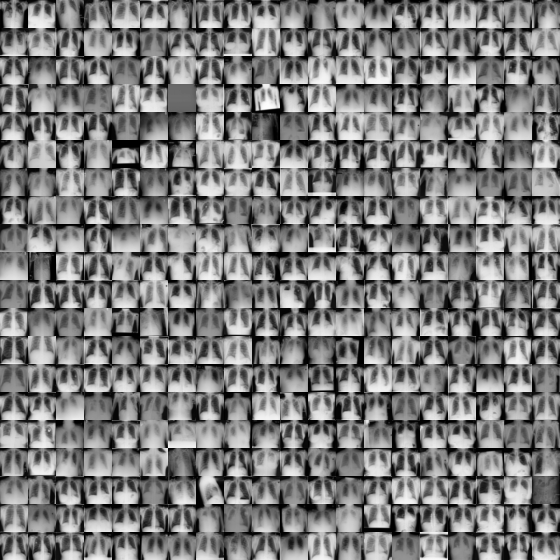

In [5]:
train_dataset.montage(length=20)

**Какие преобразования вы применили при создании DataSet и почему?**

Ваш ответ: При создании DataSet для ChestMNIST были применены следующие преобразования, используя PyTorch и torchvision:

Преобразование в Тензор (transforms.ToTensor()):

Это преобразование конвертирует PIL-изображения или NumPy-массивы в тензоры PyTorch.
Важно, потому что нейронные сети, обучаемые с помощью PyTorch, работают с данными в формате тензоров.
Также автоматически масштабирует данные изображения к диапазону [0, 1], что является стандартной практикой для улучшения сходимости во время обучения.

## Создание модели

Автокодировщик (автоэнкодер) состоит из двух частей и вывод первой части является входом второй части. Строение модели вы можете посмотреть в статье в описании и воспроизвести ее. Создание слоев свертки вам знакомо с предыдущей работы, а для декодера вам потребуется двумерная транспонированная свертка (ConvTranspose2d).

In [6]:
#Encoder сжимает входные данные в представление с меньшей размерностью, а Decoder пытается воссоздать входные данные из этого сжатого представления.
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),  # Свертка
            nn.ReLU(),  # Активация
            nn.Conv2d(16, 32, 3, 2, 1), #применяет 16 фильтров с размером ядра 3 и использует шаг 2 с заполнением, что помогает уменьшить пространственные размеры выхода.
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  #  увеличивает количество каналов до 64 и использует размер ядра 7, без заполнения, 
            #что приводит к более значительному уменьшению пространственных размеров по сравнению с предыдущими слоями.
        )

    def forward(self, x): #прямой проход
        return self.conv(x)

class Decoder(nn.Module):
    #используемые для увеличения входного тензора до большего пространственного размера.
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            #принимает 64-канальное закодированное представление и уменьшает количество каналов до 32 с размером ядра 7.
            nn.ConvTranspose2d(64, 32, 7),  # Транспонированная свертка
            nn.ReLU(),
            #дополнительно уменьшает количество каналов до 16 и использует размер ядра 3 с шагом 2
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            #выдает одноканальное изображение с размером ядра 3, также используя шаг 2 с заполнением
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Sigmoid для нормализации выходных данных
        )

    def forward(self, x):
        return self.conv(x)

**В чем разница между сверткой и транспонированной сверткой?**

Ваш ответ: Свертка (Convolution) и транспонированная свертка (ConvolutionTranspose или Deconvolution) представляют собой две разные операции в области глубокого обучения.

**Свертка:**\
Операция: Проход фильтра (ядро) через входные данные для выделения признаков. Это уменьшает размерность данных.
Применение: Используется в процессе извлечения признаков, уменьшения размерности и обнаружения шаблонов в изображениях.

**Транспонированная свертка (ConvTranspose):**\
Операция: Увеличение размерности данных. Производит обратную операцию свертки.


Далее кодировщик и декодировщик мы объединяем в автокодировщик.

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        self.encoder.to(device)
        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Обучение

В качестве оптимизатора можете использовать SGD или Adam или в целом попробовать другие оптимизаторы, что предлагает pytorch.

В качестве функции потерь воспользуйтесь MSE (MSELoss) или другой функцией, которая подходит для сравнения изображений.

In [8]:
# Загрузка валидационного набора данных
val_dataset = DataClass(split='val', transform=transform, download=True)

# Создание DataLoader для валидационного набора
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

# Параметры
epochs = 1# кол-во эпох
learning_rate = 1e-2  # Скорость обучения

# Модель, функция потерь и оптимизатор
encoder = Encoder()
decoder = Decoder()
model = Autoencoder(encoder, decoder).to(device)

criterion = MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Словарь для логирования
log_dict = {
    'training_loss': [],
    'validation_loss': [],
}

Using downloaded and verified file: C:\Users\Al200\.medmnist\chestmnist.npz


In [9]:
from tqdm import tqdm
# Цикл обучения
for epoch in range(epochs):
    # Обучение
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')

    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_loader), total=len(train_loader)):

        if step % 1000 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))

        batch = [r.to(device) for r in batch]
        images, _ = batch   # Предполагается, что DataLoader возвращает пару (изображение, метка)

        # Добавление шума
        noisy_images = images + torch.randn_like(images).to(device) * 0.05
        noisy_images = noisy_images.clamp(0, 1)  # Ограничиваем значения пикселей

        optimizer.zero_grad()  # Обнуляем градиенты

        # Реконструкция
        outputs = model(noisy_images)
        loss = criterion(outputs, images)  # Сравнение с оригинальными изображениями

        total_train_loss += loss.item()

        # Обратное распространение
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    log_dict['training_loss'].append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    # Валидация
    print("")
    print("Running Validation...")

    total_eval_loss = 0

    model.eval()

    for batch in tqdm(val_loader, total=len(val_loader)):

        batch = [r.to(device) for r in batch]
        val_images, _ = batch

        # Реконструкция
        with torch.no_grad():
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_images)

        total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(val_loader)
    log_dict['validation_loss'].append(avg_val_loss)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

print("")
print("Training complete!")


======== Epoch 1 / 1 ========
Training...


  0%|          | 0/1227 [00:00<?, ?it/s]

 82%|████████▏ | 1007/1227 [00:18<00:03, 67.46it/s]

  Batch 1,000  of  1,227.


100%|██████████| 1227/1227 [00:22<00:00, 55.42it/s]



  Average training loss: 0.14

Running Validation...


100%|██████████| 176/176 [00:02<00:00, 75.27it/s]

  Validation Loss: 0.10

Training complete!


**Что делает clip() или clamp() и почему его требуется использовать после добавления шума?**

Ваш ответ: Функции clip() в Python и clamp() в PyTorch выполняют похожую задачу: они ограничивают значения в массиве или тензоре, устанавливая минимальное и максимальное значение, которые может принимать каждый элемент. Если значение элемента выходит за пределы указанного диапазона, оно будет установлено на ближайший граничный элемент этого диапазона.

В общем, clamp() используется для поддержания значений пикселей внутри допустимого диапазона после того, как к ним применяется какое-либо возмущение (например, добавление шума). Это обеспечивает, что данные останутся осмысленными и подходящими для дальнейшей обработки.

## Контроль результатов и экспериментов

Вы всегда должны следить за тем как идет обучение и как меняются метрики в его процессе. В этой работе вы можете воспользоваться [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html) или создать переменную со списком и в него складывать значения с каждых n итераций и с помощью matplotlib строить графики.

Далее приведены части кода, которые позволят в Google Colab воспользоваться TensorBoard для PyTorch.

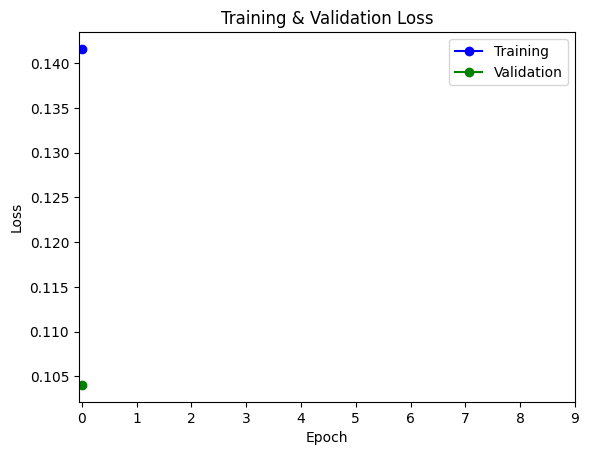

In [10]:
from matplotlib import pyplot as plt

plt.plot(log_dict['training_loss'], 'b-o', label="Training")
plt.plot(log_dict['validation_loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

plt.show()


**По графикам потерь и метрике сделайте вывод была ли модель обучена, недообучена или переобучена.**

Ваш ответ: Видно, что train loss стабильно падает => модель обучается. Однако на этапе валидации видно, что loss "ветвляет". Это может быть связно с тем, что наша модель недостаточно сложная.

**Если модель недообучена или переобучена, то что могло послужить причинами этого?**

Ваш ответ:

Если бы модель была недообучена, это могло бы быть связано с малым количеством эпох обучения, или малым размером батча, или слишким большим learning rate (в таком случае, мы могли попасть в локальный, а не глобальный минимум).

Если бы модель была переобучена, то график валидационного лосса в какой-то момент пошел бы вверх, а трейн лосс все так бы и продолжал падать, так что это тоже не наш случай (хотя, может и наш, потому что валидационный лосс колеблется). Переобучение могло возникнуть, наоборот, из-за слишком большого числа эпох, из-за недостаточной сложности модели, из-за маленького размера данных.

## Результат работы модели

Выведите итоговую метрику для тестовых изображений. И отобразите несколько примеров работы модели: исходное изображение и с убранным шумом.

Пример для цветных изображений.

```python
test_images = test_images.to(device)
with torch.no_grad():
  reconstructed_imgs = network(test_images)
reconstructed_imgs = reconstructed_imgs.cpu()
test_images = test_images.cpu()
imgs = torch.stack([test_images.view(-1, 3, 32, 32), reconstructed_imgs], dim=1).flatten(0,1)
grid = make_grid(imgs, nrow=10, normalize=True, padding=1)
grid = grid.permute(1, 2, 0)
plt.figure(dpi=170)
plt.title('Original/Reconstructed')
plt.imshow(grid)
log_dict['visualizations'].append(grid)
plt.axis('off')
plt.show()
```

In [11]:
# использование обученной модели для восстановления (реконструкции) изображений из тестового набора данных.
for batch in test_loader:
    test_images, _ = batch

    test_images = test_images.to(device)
    with torch.no_grad():
      reconstructed_imgs = model(test_images)
    reconstructed_imgs = reconstructed_imgs.cpu()
    test_images = test_images.cpu()

In [12]:
#конвертирует тензоры PyTorch, содержащие реконструированные изображения (reconstructed_imgs) и исходные тестовые изображения (test_images), в массивы NumPy.
reconstructed_imgs_np = reconstructed_imgs.numpy()
test_images_np = test_images.numpy()

In [13]:
# import math

# # Функция для отображения оригинальных и восстановленных изображений (1 батч)
# def plot_images(original_images, reconstructed_images, nrow=10):
#     num_images = original_images.shape[0]
#     num_rows = math.ceil(num_images / nrow)

#     fig, axes = plt.subplots(num_rows, nrow * 2, figsize=(nrow * 3, num_rows * 2))

#     for i in range(num_rows):
#         for j in range(nrow):
#             index = i * nrow + j
#             if index < num_images:
#                 # Оригинальное изображение
#                 axes[i, j * 2].imshow(original_images[index, 0], cmap='gray')
#                 axes[i, j * 2].axis('off')
#                 axes[i, j * 2].set_title('Original')

#                 # Восстановленное изображение
#                 axes[i, j * 2 + 1].imshow(reconstructed_images[index, 0], cmap='gray')
#                 axes[i, j * 2 + 1].axis('off')
#                 axes[i, j * 2 + 1].set_title('Reconstructed')
#     plt.show()

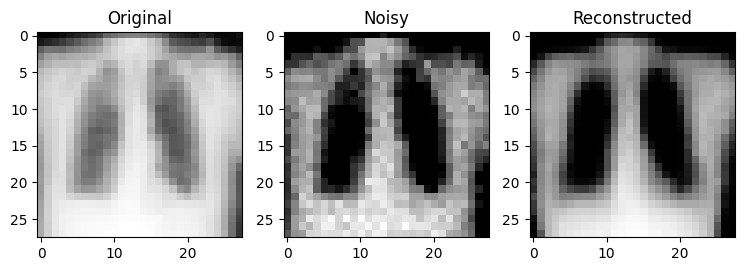

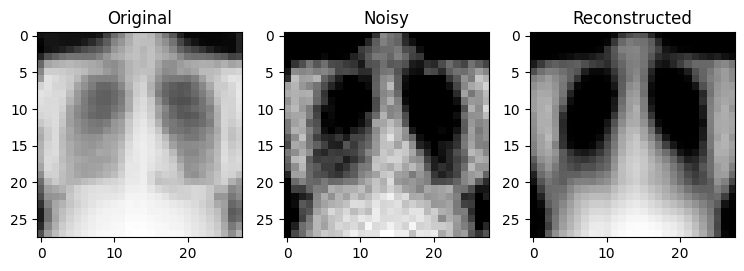

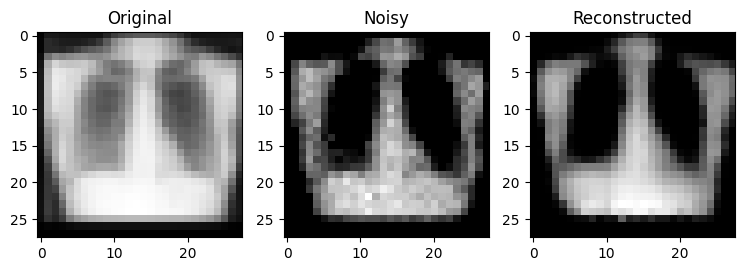

In [16]:
num_examples = 5
model.eval()
# Выберем случайные изображения из тестового набора данных
sample_indices = torch.randint(0, len(test_loader), (num_examples,))
#36
list = [1101, 26, 237]
# for _, index in enumerate(sample_indices):
for index in list:
    with torch.no_grad():
        test_image = test_loader.dataset[index][0].to(device)
        noisy_image = test_image + (torch.randn_like(test_image) * 0.05)
        noisy_image = torch.clip(noisy_image, 0., 1.)

        output_image = model(noisy_image)

    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(test_image.squeeze().cpu().numpy(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Noisy')
    plt.imshow(noisy_image.squeeze().cpu().numpy(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Reconstructed')
    plt.imshow(output_image.squeeze().cpu().numpy(), cmap='gray')

    plt.show()



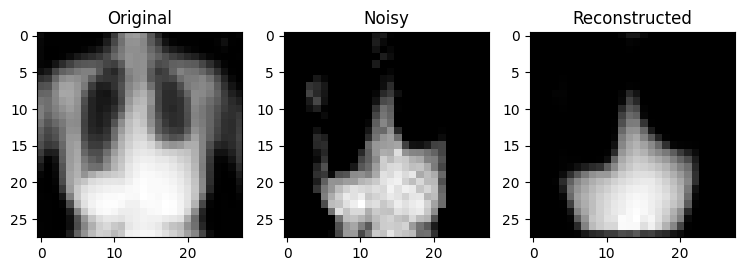

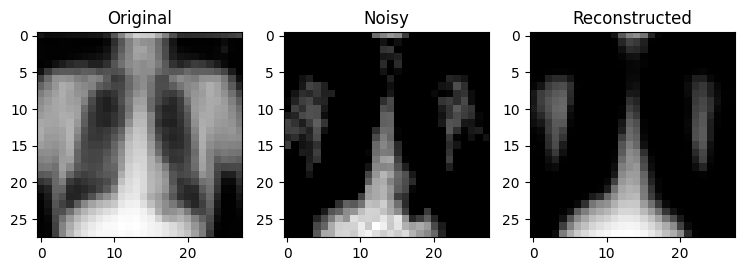

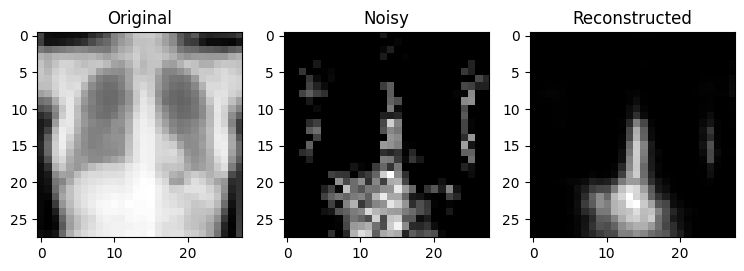

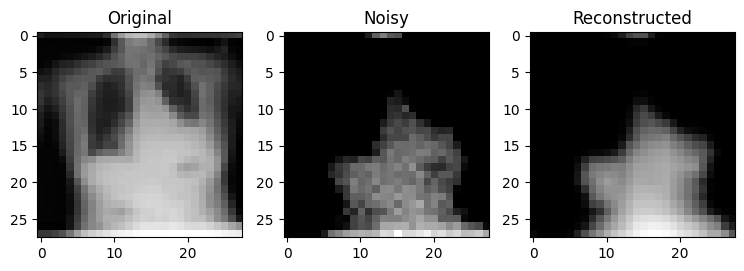

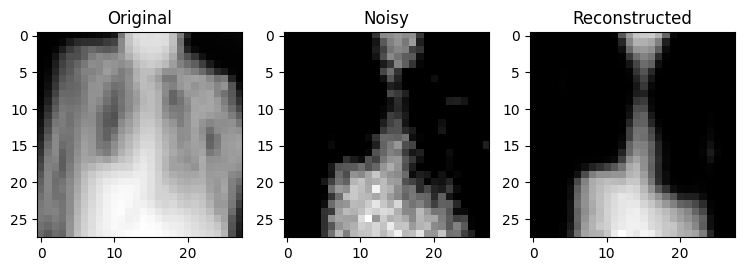

In [21]:
num_examples = 5
model.eval()
# Выберем случайные изображения из тестового набора данных
sample_indices = torch.randint(0, len(test_loader), (num_examples,))

for _, index in enumerate(sample_indices):
    with torch.no_grad():
        test_image = test_loader.dataset[index][0].to(device)
        noisy_image = test_image + (torch.randn_like(test_image) * 0.05)
        noisy_image = torch.clip(noisy_image, 0., 1.)

        output_image = model(noisy_image)

    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(test_image.squeeze().cpu().numpy(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Noisy')
    plt.imshow(noisy_image.squeeze().cpu().numpy(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Reconstructed')
    plt.imshow(output_image.squeeze().cpu().numpy(), cmap='gray')

    plt.show()

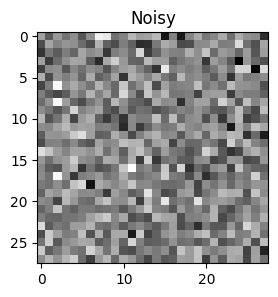

In [17]:
plt.figure(figsize=(9, 3))
noisy_image = torch.randn_like(images[0]).to(device) * 0.05
plt.title('Noisy')
plt.imshow(noisy_image.squeeze().cpu().numpy(), cmap='gray')
plt.show()

In [18]:
# plot_images(test_images_np, reconstructed_imgs_np, nrow=7)

Для оценки производительности модели Denoising Autoencoder (DAE) можно использовать среднеквадратичное отклонение (Mean Squared Error, MSE) между оригинальными изображениями и их восстановленными версиями. Низкое значение MSE указывает на хорошую производительность модели.

In [19]:
# расчёт среднеквадратичной ошибки (MSE) между исходными тестовыми изображениями и реконструированными изображениями.
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_images_np.flatten(), reconstructed_imgs_np.flatten())
print(f"Mean Squared Error (MSE) on test images: {mse}")
# Чем ниже значение MSE, тем ближе реконструированные изображения к исходным, и, соответственно, тем лучше качество реконструкции, выполняемой моделью автоэнкодера.

Mean Squared Error (MSE) on test images: 0.14742237329483032


По значению метрики видно, что модель неплохо справляется со своей задачей. Однако на визуализации кажется, что модель "вырезает" слишком много полезной информации, но все-таки главную деталь картинки - контур легких, модель старается сохранять.

## Контрольные вопросы

**В чем особенность архитектуры автокодировщиков?**

Ваш ответ:

Автокодировщик состоит из двух основных частей: кодировщика (Encoder) и декодировщика (Decoder). Encoder преобразует входные данные в скрытое представление (код), а Decoder восстанавливает из этого представления исходные данные.

Обычно в середине автокодировщика есть слой с меньшим количеством нейронов, который представляет собой "бутылочное горлышко". Это ограничивает количество информации, которое может пройти через код, заставляя модель извлекать ключевые признаки.

Автокодировщики часто используются для снижения размерности данных, сохраняя при этом важные характеристики.

Основная цель обучения - минимизировать разницу между входными данными и их реконструкцией.

**Какие метрики можно использовать для оценки качества изображений?**

Ваш ответ:

Среднеквадратичная ошибка (MSE) - метрика для оценки различия между оригинальным и восстановленным изображением.\
*Примечание*: помимо MSE можно использовать MAE, RMSE и т.п..

Структурное сходство (SSIM) - метрика, которая учитывает восприятие структурного сходства между изображениями.

Косинусное сходство - может использоваться для измерения угла между векторами пиксельных значений оригинального и восстановленного изображений.


